In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
with open("img/Dino/dino.txt") as f:
    a = f.readlines()
f.close()

In [3]:
xks = []
for i in range(len(a[1:-1])-1):
    xks.append([float(j) for j in a[i+1].split()])
xks = np.array(xks)
mu = np.mean(xks.T,axis=1)
xks = (xks.T - mu[:,np.newaxis]).T
xks.shape

(555, 3)

(555, 3)

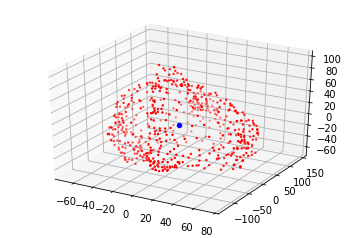

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mu = np.mean(xks.T,axis=1)
ax.scatter(xs=xks[:,0],ys=xks[:,1],zs=xks[:,2],s=2,c="r")
ax.scatter(xs=mu[0],ys=mu[1],zs=mu[2],s=20,c="b")
xks.shape

In [5]:
def chop_axis(i,xks,plot=False):
    U,S,V = np.linalg.svd(xks,False)

    keep = np.squeeze(np.argwhere(U[:,i]> -.001))

    xks_= (U[keep,:].dot(np.diag(S)))
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(xs=xks_[:,0],ys=xks_[:,1],zs=xks_[:,2],s=2,c="r")
        ax.scatter(xs=0,ys=0,zs=0,s=20,c="b")
    return xks_

In [6]:
def homog(xk):
    ones = np.ones(xk.shape[1])
    return np.vstack([xk,ones])

def project(M,xks,plot=True):
    plt.figure()
    pc = M.dot(homog(xks.T))
    pc = pc[:2,:]/pc[2,:]
    pc_mu = np.mean(pc,axis=1)
    if plot:
        plt.scatter(pc[0,:],pc[1,:],c="r",s=20)
        plt.scatter(pc_mu[0],pc_mu[1],c="b",s=20)
    return pc

In [7]:
class proj_Matrix:
    def __init__(self,e,g,**params):
        self.e = e
        self.g = g
        self.f = 1
        self.ox = 0
        self.oy = 0
        self.s = 1
        
        if isinstance(params,dict):
            for k,v in params.items():
                self.__dict__[k]=v
                
        self.compute_camera_axis()
        self.build_Mint()
        self.build_Mext()
        self.build_M()
    
    def compute_camera_axis(self): 
        e = self.e
        g = self.g 
        
        w = -g/np.linalg.norm(g)
        
        t = np.array([0,1,0])
        u = np.cross(t,w)/np.linalg.norm(np.cross(t,w))
        v = np.cross(w,u)
          
        self.u = u
        self.v = v
        self.w = w
        
    def build_Mint(self):
        self.Mint = np.array([[self.f/self.sx,0,0,self.ox],[0,self.f/self.sy,0,self.oy],[0,0,1/self.f,0]])
        
    def build_Mext(self):    
        Mr = np.array([self.u,self.v,self.w]).T
        self.Mcw = np.vstack((np.hstack([Mr,self.e[:,np.newaxis]]),np.append(np.zeros(3),1)))
        self.Mwc = np.vstack((np.hstack([Mr.T,-Mr.T.dot(self.e[:,np.newaxis])]),np.append(np.zeros(3),1)))
    
    def build_M(self):
        self.M = self.Mint.dot(self.Mwc)

In [8]:
from mpl_toolkits.mplot3d import Axes3D
class camera(proj_Matrix):
    def __init__(self,ex,ey,ez,**params):
        self.e = np.array([ex,ey,ez])
        self.target = np.zeros(3)
        self.f=25
        self.ox = 0
        self.oy = 0
        self.sx=1
        self.sy=1
        
        if isinstance(params,dict):
            for k,v in params.items():
                self.__dict__[k]=v
        
        self.reset_direction(self.target)
                
    def plot_center(self,xks=None):
        ex,ey,ez = self.e
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xs=ex,ys=ey,zs=ez,s=50,c="b")
        if isinstance(xks,np.ndarray):
            mu = np.mean(xks.T,axis=1)
            ax.scatter(xs=xks[:,0],ys=xks[:,1],zs=xks[:,2],s=2,c="r")
            ax.scatter(xs=mu[0],ys=mu[1],zs=mu[2],s=20,c="b")
            
            ax.plot(xks[:,0], xks[:,2], 'r+', zdir='y', zs=250)
            ax.plot(xks[:,1], xks[:,2], 'g+', zdir='x', zs=-150)
            ax.plot(xks[:,0], xks[:,1], 'k+', zdir='z', zs=-250)
            
     
    def reset_direction(self,target,**params):
        #if isinstance(params,dict):
        for k,v in params.items():
            self.__dict__[k]=v
                
        self.g =  self.e -target 
        self.g = -self.g/np.linalg.norm(self.g)
        self.compute_camera_axis()
        self.build_Mint()
        self.build_Mext()
        self.build_M()

In [9]:
def preview(xks_,f=10,ox=1,oy=1,sx=1000,sy=1000):

    c1 = camera(-150,0,0,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(150,0,0,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(0,-150,1,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(0,150,1,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(0,0,150,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(0,0,-150,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(150,150,150,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)


    c1 = camera(-150,-150,-150,**{"xc":np.array([0,0,0]),"f":f,"sx":sx,"sy":sy,"ox":ox,"oy":oy})
    c1.plot_center(xks_)
    _ = project(c1.M,xks_,plot=True)

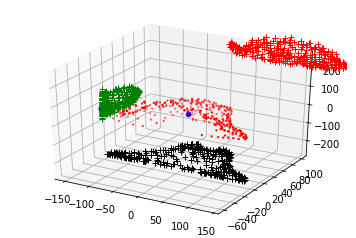

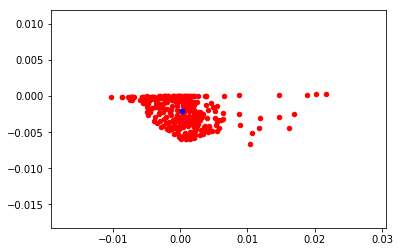

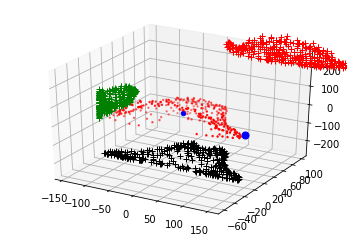

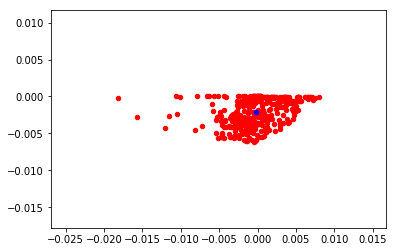

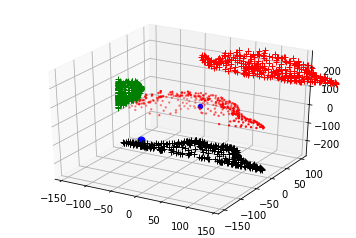

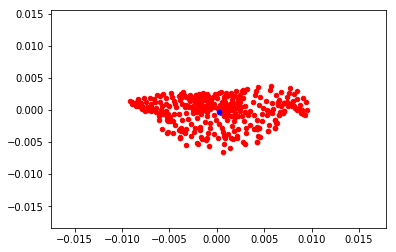

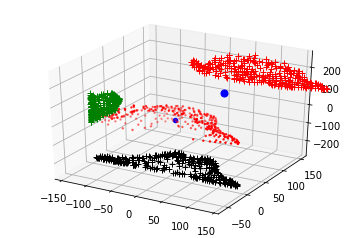

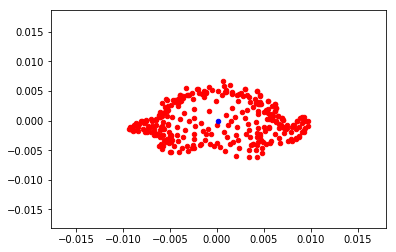

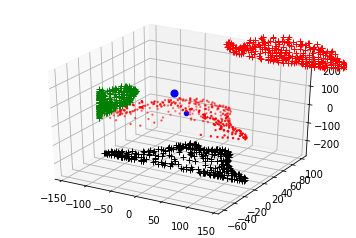

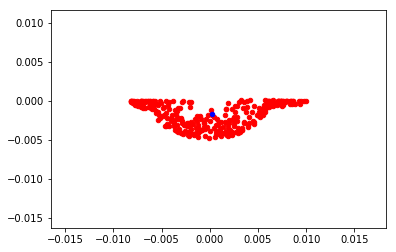

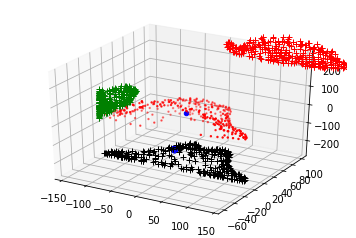

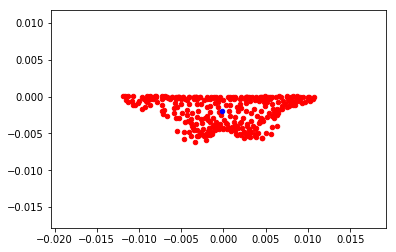

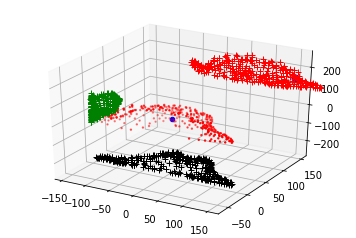

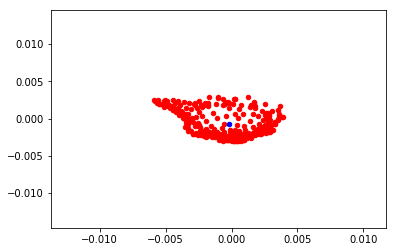

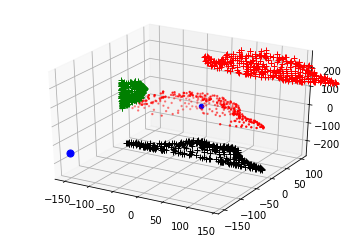

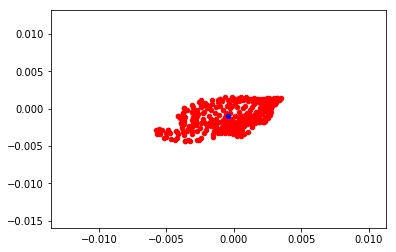

In [10]:
preview(chop_axis(1,xks),f=1,sx=100,sy=100,ox=0.001,oy=0.001)

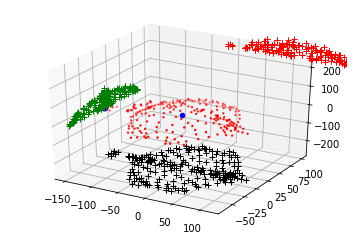

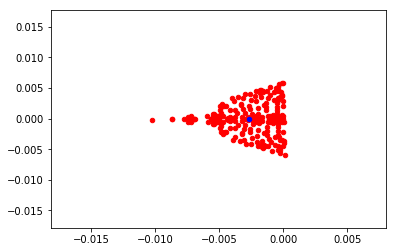

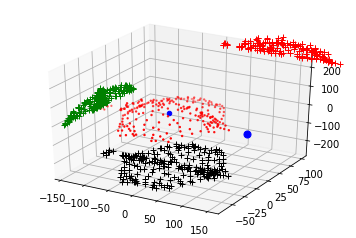

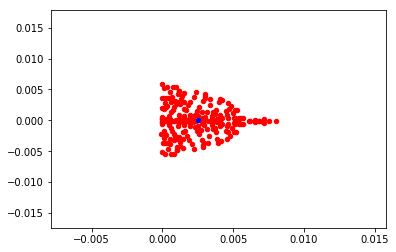

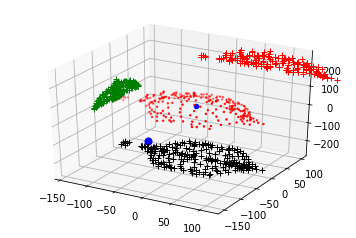

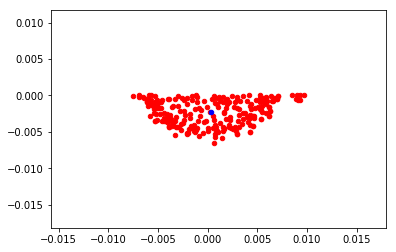

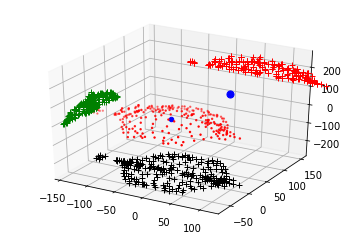

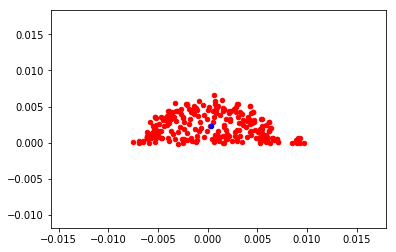

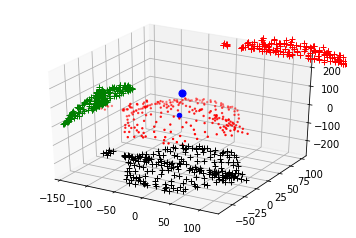

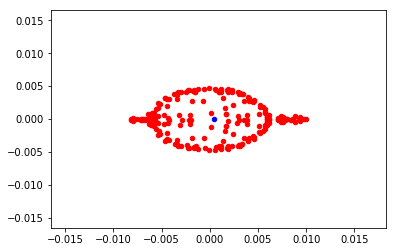

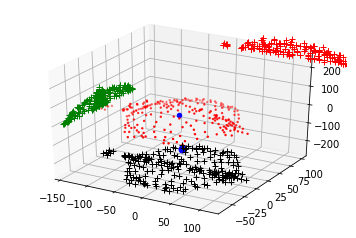

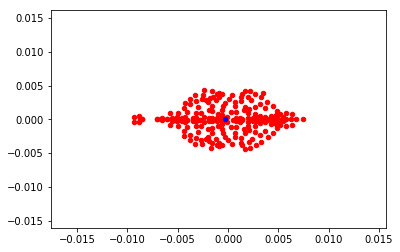

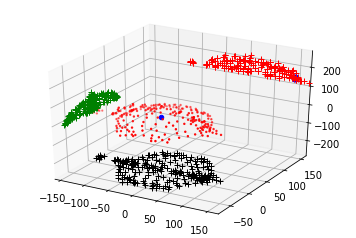

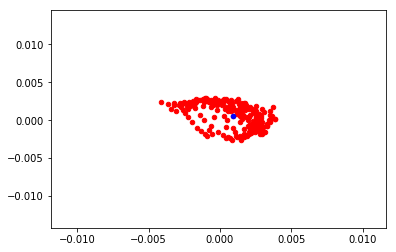

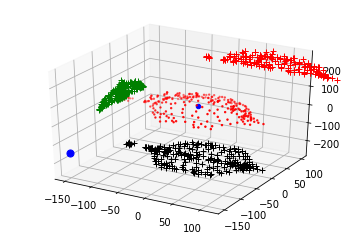

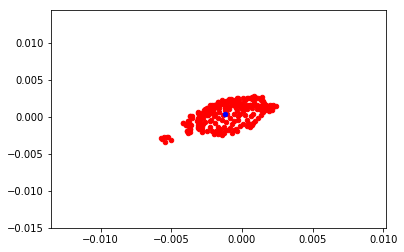

In [11]:
preview(chop_axis(2,xks),f=1,sx=100,sy=100,ox=0.001,oy=0.001)

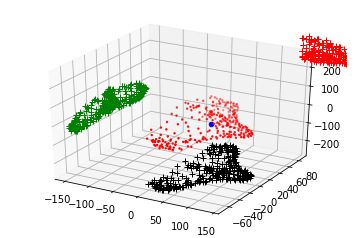

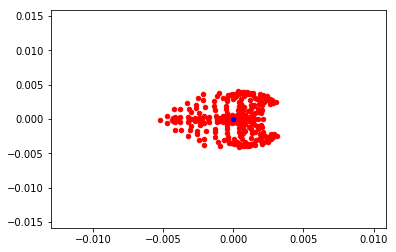

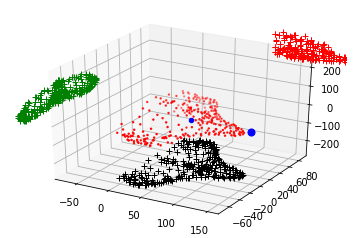

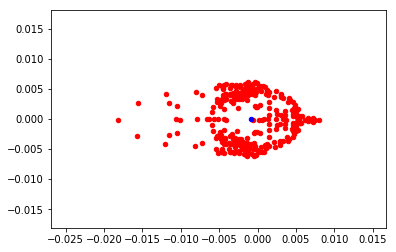

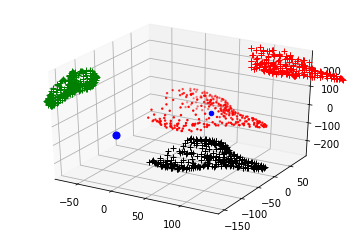

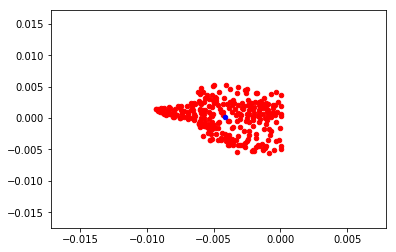

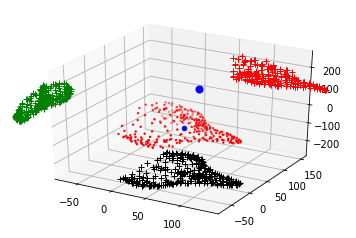

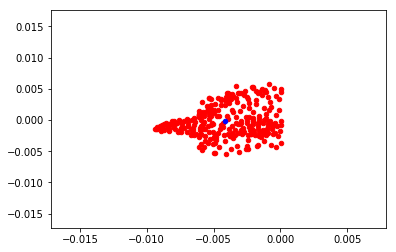

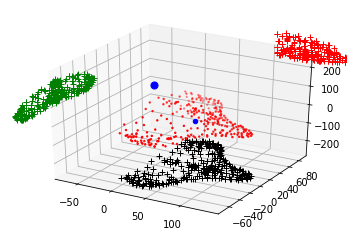

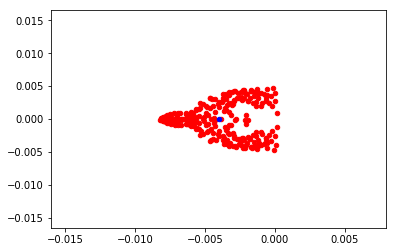

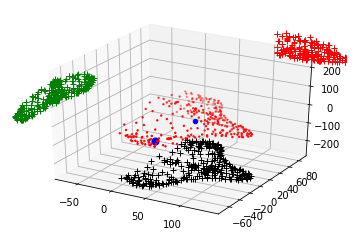

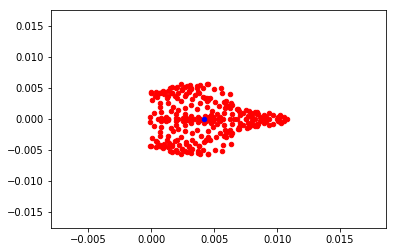

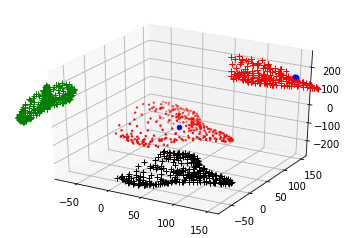

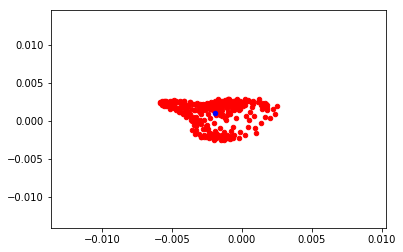

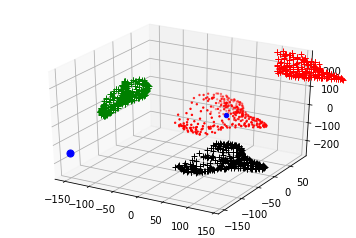

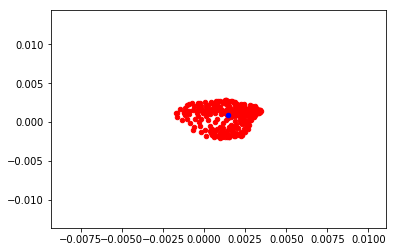

In [12]:
preview(chop_axis(0,xks),f=1,sx=100,sy=100,ox=0.001,oy=0.001)

In [13]:
class StereoPair:
    def __init__(self,ex,ey,ez,d,xks,plot=True,**params):
        cam1 = camera(ex,ey,ez,**params)

        if plot: cam1.plot_center(xks)
        self.xk1 = project(cam1.M,xks,plot=True)

        cam2 = camera(ex+d[0],ey+d[1],ez+d[2],**params)
        
        if plot:cam2.plot_center(xks)
        self.xk2 = project(cam2.M,xks,plot=True)
        
    def computeF(self):
        
        pass
    
    def noisyProjections(self,sig=1):
        self.noisy_xk1 = np.random.randn(self.xk1.shape[0],self.xk1.shape[1])*sig+self.xk1
        self.noisy_xk2 = np.random.randn(self.xk2.shape[0],self.xk2.shape[1])*sig+self.xk2
        
        pass

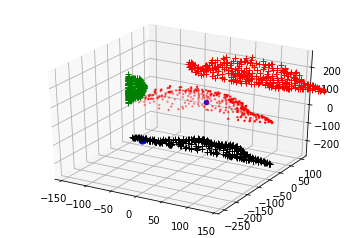

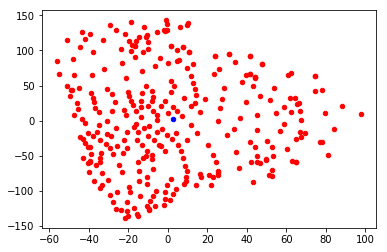

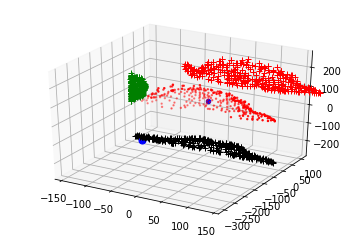

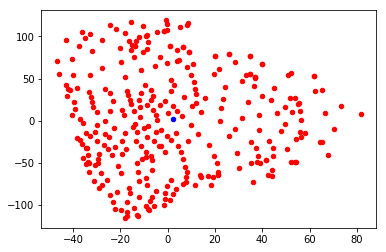

In [14]:
par = {"xc":np.array([0,0,0]),"f":50,"sx":10,"sy":10,"ox":0,"oy":0}
stereo = StereoPair(ex=1,ey=-250,ez=0,d=np.array([0,-50,0]),xks=chop_axis(1,xks),**par)

In [15]:
stereo.noisyProjections()